## Load in imports and data

In [52]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# NO_DATA investigation
import lsst.geom as geom

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

Confirm that local packages are being used, tested with `pipe_tasks` and `drp_tasks`. Need to check this at least until these package versions are in the main stack.

In [35]:
import lsst.pipe.tasks
import lsst.drp.tasks
print(lsst.pipe.tasks.__file__)
print(lsst.drp.tasks.__file__)

/home/m/mgorsuch/rubin-user/repos/pipe_tasks/python/lsst/pipe/tasks/__init__.py
/home/m/mgorsuch/rubin-user/repos/drp_tasks/python/lsst/drp/tasks/__init__.py


In [36]:
collection = 'u/mgorsuch/assemble_cell_coadd_patch_61/20240403T183342Z' # for the patch 61 collection, with 8 detected warps.

In [3]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [4]:
stitch_coadd = coadd.stitch()

In [34]:
cell_list = list(coadd.cells.keys())

## 1D Cell Inputs

In [7]:
inputs_list = []
for cell in cell_list:
    cell_inputs = coadd.cells[cell].inputs
    inputs_list.append(len(cell_inputs))
inputs_list = np.array(inputs_list)
print(inputs_list)

[7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 4 4 5 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6
 5 4 4 5 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 4 4 5 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 3 3 2 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 1 1 1 2 2 2 2 5
 5 5 5 4 4 4 5 5 5 5 5 5 4 4 4 4 4 4 3 3 3 5 5 5 5 4 4 4 5 5 5 5 5 5 4 4 4
 4 4 4 3 3 3 7 7 7 7 6 6 6 7 7 7 7 7 7 6 6 5 4 4 5 5 5 5 7 7 7 7 6 6 6 7 7
 7 7 7 7 6 6 5 4 4 5 5 5 5 6 6 6 6 5 5 5 6 6 6 6 6 6 5 5 4 3 3 4 4 4 4 6 6
 6 6 5 5 5 6 6 6 6 6 6 5 5 4 3 3 4 4 4 4 7 7 7 7 6 6 6 7 7 7 7 7 7 6 6 5 4
 4 5 5 5 5 6 6 6 6 5 5 5 6 6 6 6 6 6 6 6 5 4 4 5 5 5 5 6 6 6 6 5 5 5 6 6 6
 6 6 6 6 6 5 4 4 5 5 5 5 7 7 7 7 6 6 6 7 7 7 7 7 7 6 6 5 4 4 5 5 5 5 7 7 7
 7 6 6 6 7 7 7 7 7 7 6 6 5 4 4 5 5 5 5 7 7 7 7 6 6 6 7 7 7 7 7 7 6 6 5 4 4
 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 2 1 1 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 3 2 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 4 4 4 4
 3 3 3 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 4 4 4 4 4 4 3 3 3 3 3 4
 5 5 5]


### Plotting cell input 1D histogram

(array([  0.,   9.,  21.,  71., 119.,  85.,  80.,  99.,   0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

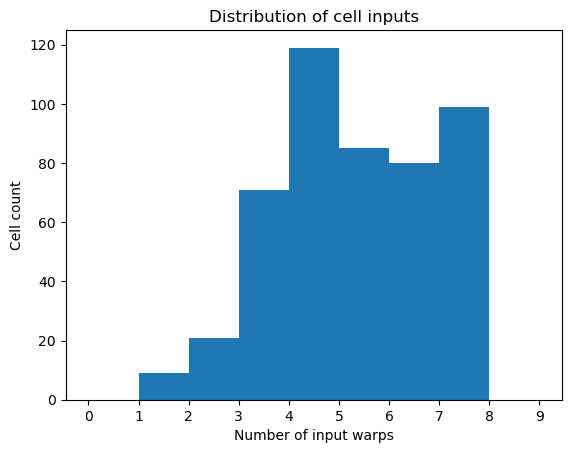

In [9]:
bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(inputs_list, bins)

## Investigate NO_DATA

Find the cell that contains a large amount of NO_DATA masked pixels.
- The 2305, 715 coordinate is found using the Firefly display and hovering over the masked pixels. The readout option should be set to FITS Image Pixel. However, the coadd object does not have an origin at 0,0. This offset must be added, and is found using `getMin()` method.

In [37]:
print(coadd.grid.index(coadd.inner_bbox.getMin()+(geom.Extent2I(2305, 715))))

Index2D(x=15, y=4)


Alterate way to determine NO_MASK cell

In [12]:
print(coadd.grid.index(geom.Point2I(20105,15512)))

Index2D(x=15, y=4)


Find the input warps used in this cell:

In [13]:
cell_no_data = coadd.cells[Index2D(x=15, y=4)]
print(cell_no_data.inputs)

frozenset({ObservationIdentifiers(instrument='HSC', packed=4690, visit=19684, detector=50)})


Using the output above, read in the relevant warp:

In [14]:
# get the above warp with no_data from the butler
warp2 = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract=9813,
                   patch=61,
                   visit = 19684)

#### Compare the warp, stitiched coadd, and cell images

Read in the relevant warp and the cell with NO_DATA masked pixels:

In [32]:
cell_test = coadd.cells[Index2D(x=15, y=4)]

In [23]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp2.getMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

Read in the stitched coadd and the cell with NO_DATA masked pixels:

In [175]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp2.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=0, y=0)].inner.variance)

In [92]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitch_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

### Investigate NO_DATA in normal warping/coaddition process (none cell-based)
**TO-DO**: need to rerun with updated dataset types

Read in the relevant warp and coadd

## Plot mask information

There is probably a more efficient way to do this but this is for a first try

Text(0, 0.5, 'Cell count')

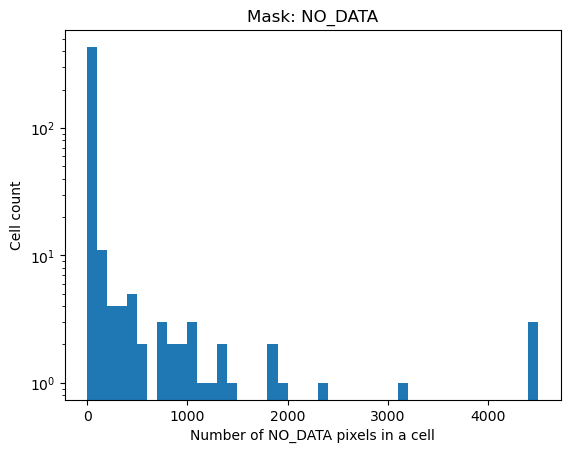

In [40]:
num_mask_pix = []
plot_mask = 'NO_DATA'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
some_cell = cell_no_data = coadd.cells[Index2D(x=1, y=1)]
mask_bit = some_cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    # optionally print cells that contain the defined masked pixels
    # if num_bad_pixels > 0:
    #     print(cell_index)
    num_mask_pix.append(num_bad_pixels)
    
num_mask_pix = np.array(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, 100)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

## Generate 2D histogram of number of cell inputs across patch 61

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [28]:
stitch_coadd.asExposure().getDimensions()

Extent2I(3400, 3400)

Get the grid structure of the stitched coadd:

In [29]:
print(stitch_coadd.grid)

UniformGrid(cell_size=Extent2I(150, 150), shape=(22, 22), min=Point2I(17850, 14850))


Arrange the number of inputs for each cell into a 2D grid:

In [10]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.empty([22,22])

for cell in cell_list:
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

Plot the 2D grid of cell inputs:

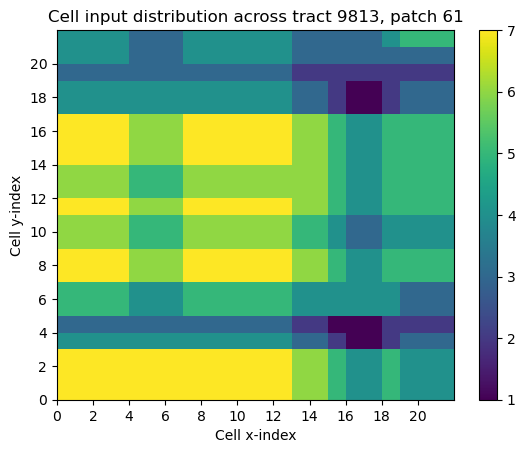

In [12]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.title("Cell input distribution across tract 9813, patch 61")
plt.xlabel("Cell x-index")
plt.ylabel("Cell y-index")
plt.colorbar()

Brief check that index of cells are lining up as expected

In [14]:
print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

7
1
6


### Display above histogram over the stitched coadd

Maybe not as useful as I had hoped, but still an interesting exercise in manipulating array images.

In [41]:
import lsst.geom as afwGeom

In [42]:
flipped_stitch = np.flip(stitch_coadd.image.getArray(), axis=0)

Many different ways to retrieve the bounding box coordinates:

In [31]:
# coadd pixel coordinates for minimum corner and maximum corner
print(stitch_coadd.bbox)
# split up the four values
print(stitch_coadd.bbox.beginX)
print(stitch_coadd.bbox.beginY)
print(stitch_coadd.bbox.maxX)
print(stitch_coadd.bbox.maxY)
# get each corner
print(stitch_coadd.bbox.getBegin())
print(stitch_coadd.bbox.getMax())

(minimum=(17800, 14800), maximum=(21199, 18199))
17800
14800
21199
18199
(17800, 14800)
(21199, 18199)


Remove the image padding (50 pixels added to each side, actual image should be 3300x3300 pixels:

In [44]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = stitch_coadd.asExposure()[bbox]
print(cutout.getDimensions())

(3300, 3300)


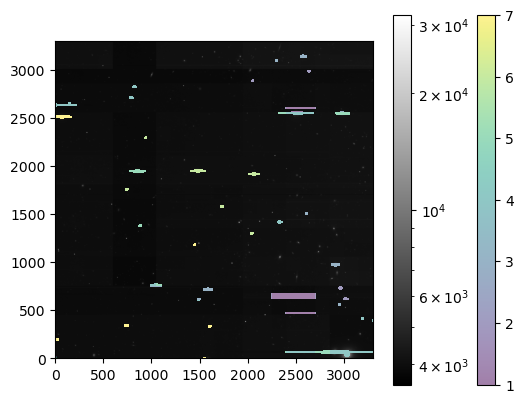

In [45]:
from matplotlib.colors import LogNorm
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), alpha=0.5)
# extent = np.min(x), np.max(x), np.min(y), np.max(y)
extent = 0, 3300, 0, 3300
im1 = plt.imshow(np.flip(inputs_list, axis=0), alpha=0.5, extent=extent)
color1 = plt.colorbar(im1)
im2 = plt.imshow(np.flip(cutout.image.getArray(), axis=0), cmap='gray', norm=LogNorm(), extent=extent)
color2 = plt.colorbar(im2)
plt.show()

## Cell Variance Distribution (WIP)

### Plot 2D histogram of cell variance

In [42]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

mean_var_list = np.empty([22,22])
median_var_list = np.empty([22,22])

for cell in cell_list:
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # ignore cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mean_var_list[y_index][x_index] = 0
        median_var_list[y_index][x_index] = 0
        print(x_index, y_index)
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mean_var_list[y_index][x_index] = mean_var
    median_var_list[y_index][x_index] = median_var

16 3
17 3
15 4
16 4
17 4
16 17
17 17
16 18
17 18


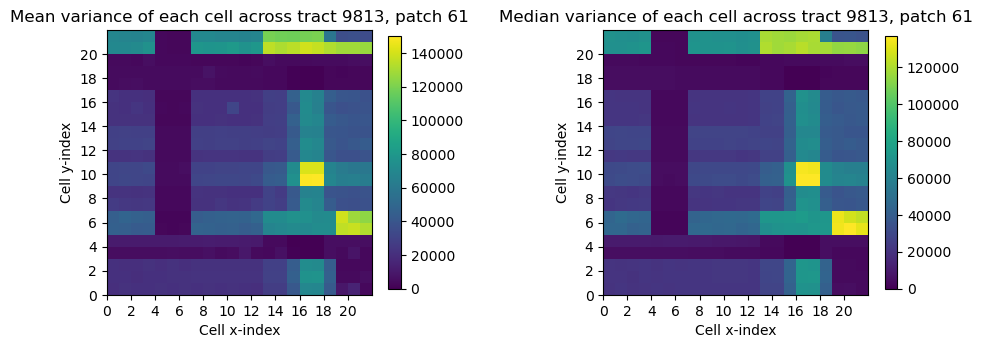

In [51]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(x_cell_bin, y_cell_bin, mean_var_list, shading='auto', vmin=mean_var_list.min(), vmax=mean_var_list.max()) # , linewidths=4
ax1.set_title("Mean variance of each cell across tract 9813, patch 61")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(x_cell_bin, y_cell_bin, median_var_list, shading='auto', vmin=median_var_list.min(), vmax=median_var_list.max())
ax2.set_title("Median variance of each cell across tract 9813, patch 61")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

### Plot 2D histogram of variance with masked cells with infinite values

In [54]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

mean_var_list = np.empty([22,22])
median_var_list = np.empty([22,22])

mask_mean_var_list = ma.masked_invalid(mean_var_list)
mask_median_var_list = ma.masked_invalid(median_var_list)

for cell in cell_list:
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mask_mean_var_list[y_index][x_index] = var_array[0][0]
        mask_median_var_list[y_index][x_index] = var_array[0][0]
        print(x_index, y_index)
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mask_mean_var_list[y_index][x_index] = mean_var
    mask_median_var_list[y_index][x_index] = median_var

16 3
17 3
15 4
16 4
17 4
16 17
17 17
16 18
17 18


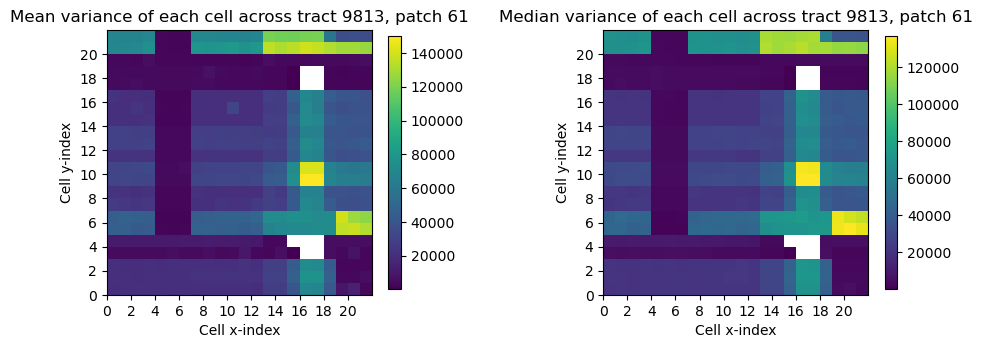

In [55]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(mask_mean_var_list, 
                               shading='auto', 
                               vmin=ma.min(mask_mean_var_list[np.isfinite(mask_mean_var_list)]), 
                               vmax=ma.max(mask_mean_var_list[np.isfinite(mask_mean_var_list)]))
ax1.set_title("Mean variance of each cell across tract 9813, patch 61")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
                             shading='auto', 
                             vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
                             vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]))
ax2.set_title("Median variance of each cell across tract 9813, patch 61")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

### Compare cell input to cell variance

#### Compare the 2D histograms

First visually compare the two graphs

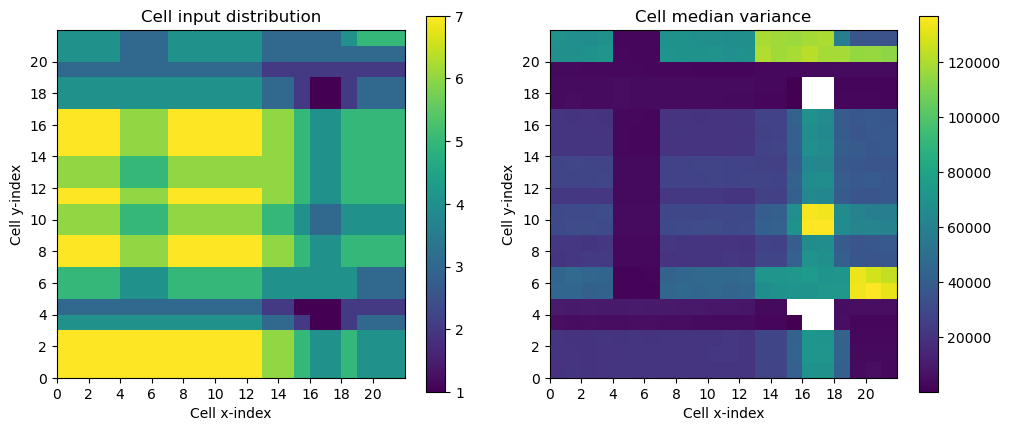

In [56]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
plt.tight_layout()

input_distrib = ax1.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
ax1.set_title("Cell input distribution")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.4)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
               shading='auto', 
               vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
               vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]),)
ax2.set_title("Cell median variance")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

#### Initial scatter plot of cell inputs and mean variance

Try a scatter plot to see if there's a relationship between numberof cell inputs and median cell varaince.

In [58]:
flat_inputs = inputs_list.flatten()
flat_median_var = mask_median_var_list.flatten()
flat_mean_var = mask_mean_var_list.flatten()

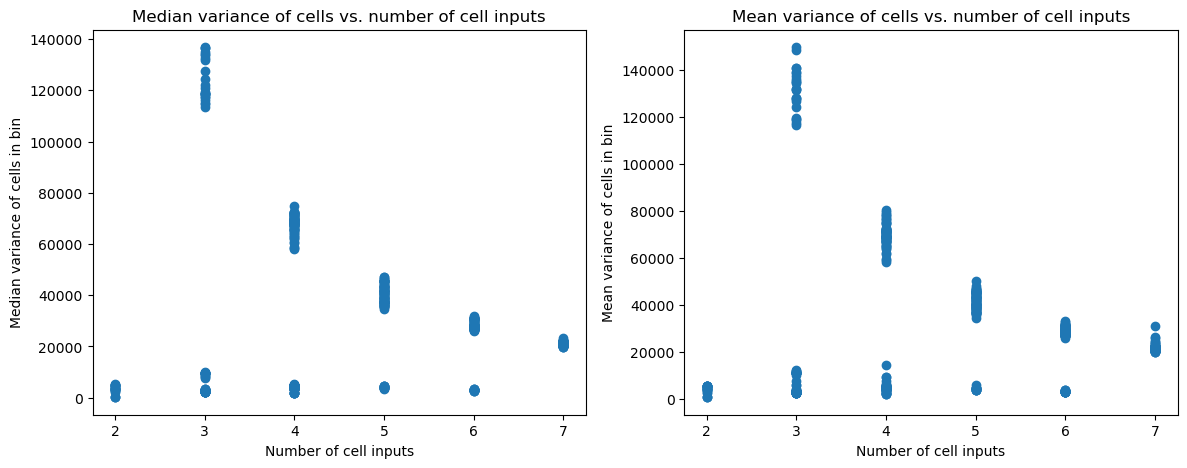

In [66]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
plt.subplots_adjust
# plt.tight_layout()

input_distrib = ax1.scatter(flat_inputs, flat_median_var)
ax1.set_title("Median variance of cells vs. number of cell inputs")
ax1.set_xlabel("Number of cell inputs")
ax1.set_ylabel("Median variance of cells in bin")
# ax1.set_aspect('equal')

var_distrib = ax2.scatter(flat_inputs, flat_mean_var)
ax2.set_title("Mean variance of cells vs. number of cell inputs")
ax2.set_xlabel("Number of cell inputs")
ax2.set_ylabel("Mean variance of cells in bin")
# ax2.set_aspect('equal')

plt.show()

#### Verify weighted mean of the variance

The weight of a cell times the mean variance should be equal to 1, as the weight is the inverse of the mean variance.

Read in the weight of each cell using methods from `_compute_weight` in `assemble_cell_coadd`.

In [12]:
# create and configure stats control object
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

In [13]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1242  1248 19680 19684 19694 19696 30482 30490]


In [68]:
accTask = AssembleCellCoaddTask()

weighted_mean_list = [[[] for j in range(22)] for i in range(22)]

for warp_visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = 61,
                       visit = warp_visit)
    
    for cell_index in cell_list:
        cell = coadd.cells[cell_index]
        
        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(warp_visit, cell_visits)):
            continue
        
        x_index = cell_index.x
        y_index = cell_index.y
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()

        weight = accTask._compute_weight(masked_im, statsCtrl)

        weighted_mean_list[x_index][y_index].append(weight)

        # verify that _compute_weight is the same as the inverse mean of the variance array of the warp
        manual_mean = np.mean(masked_im.variance.array)
        weight_manual = 1.0/manual_mean

        assert np.abs(weight_manual-weight)<0.01, "Large difference in weights"

        

    del warp

Verify that `_compute_weight` is the same as the inverse of the mean input warp variance

In [69]:
weighted_means_added = np.array([[np.sum(weighted_mean_list[i][j]) for j in range(22)] for i in range(22)])
print(weighted_means_added.shape)

(22, 22)


Get the mean variance of a cell (outer image)

In [70]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

mean_var_list = np.empty([22,22])

mask_mean_var_list = ma.masked_invalid(mean_var_list)

for cell in cell_list:
    var_array = coadd.cells[cell].outer.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mask_mean_var_list[y_index][x_index] = var_array[0][0]
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    mask_mean_var_list[y_index][x_index] = mean_var

In [71]:
print(mask_mean_var_list[15][4])
print(weighted_means_added[15][4])

2901.9228515625
0.0015393383839743058


In [72]:
weighted_mean_var = mask_mean_var_list * weighted_means_added

In [73]:
print(weighted_mean_var[0][0]) # not 1's

227.2061472503262


In [78]:
flat_inputs = inputs_list.flatten()
flat_weighted_mean_var = weighted_mean_var.flatten()

Text(0, 0.5, 'Weighted median variance of cells in bin')

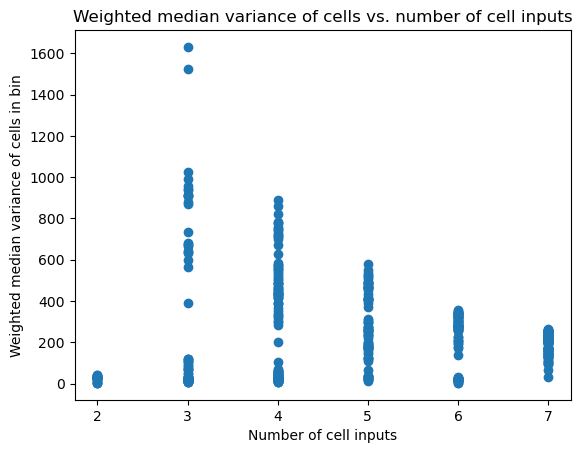

In [80]:
plt.scatter(flat_inputs, flat_weighted_mean_var)
plt.title("Weighted median variance of cells vs. number of cell inputs")
plt.xlabel("Number of cell inputs")
plt.ylabel("Weighted median variance of cells in bin")

### Look at cell images with 1 input warp (all infs values for variance)

In [19]:
inf_cell_list = np.array([[16,3],[17,3],[15,4],[16,4],[17,4],[16,17],[17,17],[16,18],[17,18]])

See if the same warp is used for all cells with 1 input

In [20]:
for cell_index in inf_cell_list:
    warp = list(coadd.cells[Index2D(x=cell_index[0],y=cell_index[1])].inputs)
    
    if len(warp)>1:
        print("over 1 warp")
        continue
    print(f"Cell index: {cell_index}, Input visit: {warp[0].visit}")

Cell index: [16  3], Input visit: 19684
Cell index: [17  3], Input visit: 19684
Cell index: [15  4], Input visit: 19684
Cell index: [16  4], Input visit: 19684
Cell index: [17  4], Input visit: 19684
Cell index: [16 17], Input visit: 19684
Cell index: [17 17], Input visit: 19684
Cell index: [16 18], Input visit: 19684
Cell index: [17 18], Input visit: 19684


In [32]:
no_data_warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = 61,
                       visit = 19684)

In [26]:
i=8
no_data_cell = coadd.cells[Index2D(x=inf_cell_list[i][0],y=inf_cell_list[i][1])]
bbox = no_data_cell.outer.bbox
masked_im = no_data_warp[bbox].getMaskedImage()

display1 = afwDisplay.Display(frame=1)
display1.mtv(no_data_cell.outer.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(masked_im.image)

Note: all cells but 2 have the `NO_DATA` mask ([16,17] and [17,18] have only `CR`, `CROSSTALK`, `DETECTED`, and `INTRP`)